Plotting the atmosphéric boundary leyer height and its hourly variations in the french Alpes based on paragliding and gliding traces. Uses the netcdf product from the netcdf code. Organised as follow :

    - Imports
    - Loading netcdf files
    - Atmospheric boundary layer map
    - Time derivative map


## Imports

In [1]:
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
import skgstat
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numba import njit
import pandas as pd
import os
from numba import jit,njit
from tqdm import tqdm
import math
import matplotlib.ticker as mticker
import xarray as xr
from tqdm import tqdm
import string

%matplotlib inline

savefig_path = 'T:/C2H/STAGES/Wiki_glide/Figures/'

@njit
def find_closest_neighbour_inside_tab(lat_l, lon_l, lat, lon):
    h,k = np.shape(lat_l)
    dist = np.ones((h,k))
    for i in range(h):
        for j in range(k):
            dist[i,j] = (lat_l[i,j] - lat)**2 + (lon_l[i,j] - lon)**2
    return np.argmin(dist)//h,np.argmin(dist)%k

@njit
def find_closest_neighbour_inside_list(lat_l, lon_l, lat, lon):
    dist = np.arange(len(lat_l))
    for i in range(len(lat_l)):
        dist[i] = (lat_l[i] - lat)**2 + (lon_l[i] - lon)**2
    return np.argmin(dist)

def select_inside_xarray(xarray,img_extent,time_step,iteration,type):
    
    if type == 'simu' :
        selected_events = xarray.where(
            (xarray['lat'] >= img_extent[2]) & (xarray['lat'] <= img_extent[3]) &
            (xarray['lon'] >= img_extent[0]) & (xarray['lon'] <= img_extent[1]) &
            (xarray['iteration'] >= iteration),
            drop=True
        )
        
    elif type == 'traces' :
        selected_events = xarray.where(
            (xarray['latitude_inf'] >= img_extent[2]) & (xarray['latitude_inf'] <= img_extent[3]) &
            (xarray['latitude_sup'] >= img_extent[2]) & (xarray['latitude_sup'] <= img_extent[3]) &
            (xarray['longitude_sup'] >= img_extent[0]) & (xarray['longitude_sup'] <= img_extent[1]) &
            (xarray['longitude_inf'] >= img_extent[0]) & (xarray['longitude_inf'] <= img_extent[1]) &
            (xarray['time_stemp'] == time_step),
            drop=True
        )       

    elif type == 'comp' :
        selected_events = xarray.where(
            (xarray['iteration'] == iteration),
            drop=True
        )

    elif type == 'comp_topo' :
        selected_events = xarray.where(
            (xarray['iteration_i'] == iteration),
            drop=True
        ) 

    elif type == 'comp_T':
        selected_events = xarray.where(
            (xarray['iteration_T'] == iteration),
            drop=True
        ) 

    elif type == 'speed' :
        selected_events = xarray.where(
            (xarray['latitude'] >= img_extent[2]) & (xarray['latitude'] <= img_extent[3]) &
            (xarray['longitude'] >= img_extent[0]) & (xarray['longitude'] <= img_extent[1]) &
            (xarray['hours'] == time_step),
            drop=True)
            
    return selected_events

from scipy.interpolate import RegularGridInterpolator

def potential_temp(temp_i,press_i,alt_i,type):
    gamma = 2/7
    rho = 1
    g = 9.81
    p0 = 100000
    
    if type == 'net':
        if np.isnan(temp_i) == False and np.isnan(alt_i) == False :
            press_net = p0-rho*g*alt_i
            t_pot=(temp_i+273.15)*(press_net/p0)**gamma - 273.15
        else :
            t_pot = np.nan
    
    elif type == 'mf':
        
        if np.isnan(temp_i) == False :
            if np.isnan(press_i) == False :
                t_pot = temp_i*(press_i/p0)**gamma - 273.15
            elif np.isnan(alt_i) == False :
                press_net = p0-rho*g*alt_i
                t_pot=(temp_i)*(press_net/p0)**gamma - 273.15
            else :
                t_pot = np.nan
        else :
            t_pot = np.nan 
    return t_pot
        

def select_inside_pdframe_2(df,iteration,extent,type):
    if type == 'net':
        selected_pd = df[(df['lat'] >=extent[2]) & (df['lat'] <= extent[3]) &
              (df['lon'] >= extent[0]) & (df['lon'] <= extent[1]) &
            (df['rawtime'] == 10*60+6*60*60+iteration*10*60)]

    elif type == 'mf':
        selected_pd = df[(df['lat'] >=extent[2]) & (df['lat'] <= extent[3]) &
              (df['lon'] >= extent[0]) & (df['lon'] <= extent[1]) &
            (df['rawtime'] == 10*60+6*60*60+iteration*10*60)]

    return selected_pd

def select_inside_pdframe(df,iteration,extent,type):
    if type == 'net':
        selected_pd = df[(df['lat'] >=extent[2]) & (df['lat'] <= extent[3]) &
              (df['lon'] >= extent[0]) & (df['lon'] <= extent[1]) &
            (df['rawtime'] == iteration*3600)]

    elif type == 'mf':
        selected_pd = df[(df['lat'] >=extent[2]) & (df['lat'] <= extent[3]) &
              (df['lon'] >= extent[0]) & (df['lon'] <= extent[1]) &
            (df['rawtime'] == iteration*3600)]

    return selected_pd

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi


def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

@njit
def find_indice_min_dist(liste_lat,liste_lon,latitude,longitude):
    n = len(liste_lat)
    res = np.zeros((1,n))[0]
    for i in range(n):
            res[i] = np.sqrt((liste_lat[i]-latitude)**2 + (liste_lon[i]-longitude)**2)
    return np.argmin(res)

@njit
def compute_press(alt_i):
    rho = 1
    g = 9.81
    p0 = 100000
    press_net = p0-rho*g*alt_i
    return press_net

def compute_dist(lat1,lon1,lat2,lon2,rad=True):
    if not(rad):
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
    # approximate radius of earth in m
    R = 6373_000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * ca

## Atmopsheric boundary layer map from netcdfs

In [2]:
BHL_19 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/19_BLH.nc')
BHL_20 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/20_BLH.nc')
BHL_21 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/21_BLH.nc')
BHL_22 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/22_BLH.nc')
BHL_23 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/23_BLH.nc')
BHL_24 = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/24_BLH.nc')


Elevation_father = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/netcds/Elevation_father.nc')

In [3]:
def plotting_BHL_spatial(xarray,elevation,vmin,vmax,pas, axs,day):
    letters = ['a','b','c','d','e','f','g','h','i','j']
    hs = list(set(xarray['heure'].values))[:-1]
    for i in range(8) :
        xarray_h = xarray.where(
            (xarray['heure'] == i+10),
            drop = True)

        lons = (xarray_h['longitude_inf'].values + xarray_h['longitude_sup'].values)/2
        lats = (xarray_h['latitude_inf'].values + xarray_h['latitude_sup'].values)/2
        c = xarray_h['PBLH'].values

        ax = axs[i//4,i%4]

        cax = ax.scatter(lons,lats,c=c,marker = 's',s = 150,alpha = 1,vmin = vmin, vmax= vmax,cmap = 'YlGnBu')

        #ax.scatter(elevation['lon'],elevation['lat'],c = elevation['elevation'],s = 1, cmap = 'terrain')
        x = Elevation_father['lon']
        y = Elevation_father['lat']
        z = Elevation_father['elevation']
        
        ax.tricontour(x, y, z, 4, linewidths=1, colors='k')
        #ax.tricontourf(x, y, z, 6,cmap = 'terrain')

        if i//4 == 0 :
            xticks = []
            xlabels = []
        else :
            xticks = np.arange(5,9,1)
            xlabels = [str(i) for i in xticks]
            ax.set_xlabel('°E',fontsize = 25)
            
        if i%4 != 0 :
            yticks = []
            ylabels = []
        else :
            yticks = np.arange(44,47,1)
            ylabels = [str(i) for i in yticks]
            ax.set_ylabel('°N',fontsize = 25)

        ax.set_xticks(xticks,xlabels,fontsize = 20)
        ax.set_yticks(yticks,ylabels,fontsize = 20)

        ax.set_xlim((5,8))
        ax.set_ylim((43.6,46.2))

        ax.set_title(str(i+10) + '-' + str(i+11)+'h '+str(day) +'/08', fontsize = 25)

        ax.text(0, 1.05, string.ascii_lowercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
        
    ticks = np.arange(vmin,vmax+pas,pas)

    cbar = plt.colorbar(cax,
                ax = axs,
                ticks=ticks,
                format=mticker.FixedFormatter(ticks),
                extend='both',
                orientation='horizontal',
                location = 'bottom',
                fraction = 0.035,
                label = ' ',
                aspect = 65,
                boundaries = ticks)
    
    cbar.ax.tick_params(labelsize=25) 
    cbar.ax.set_title(label = 'Max height flights (m asl)', fontsize=25)

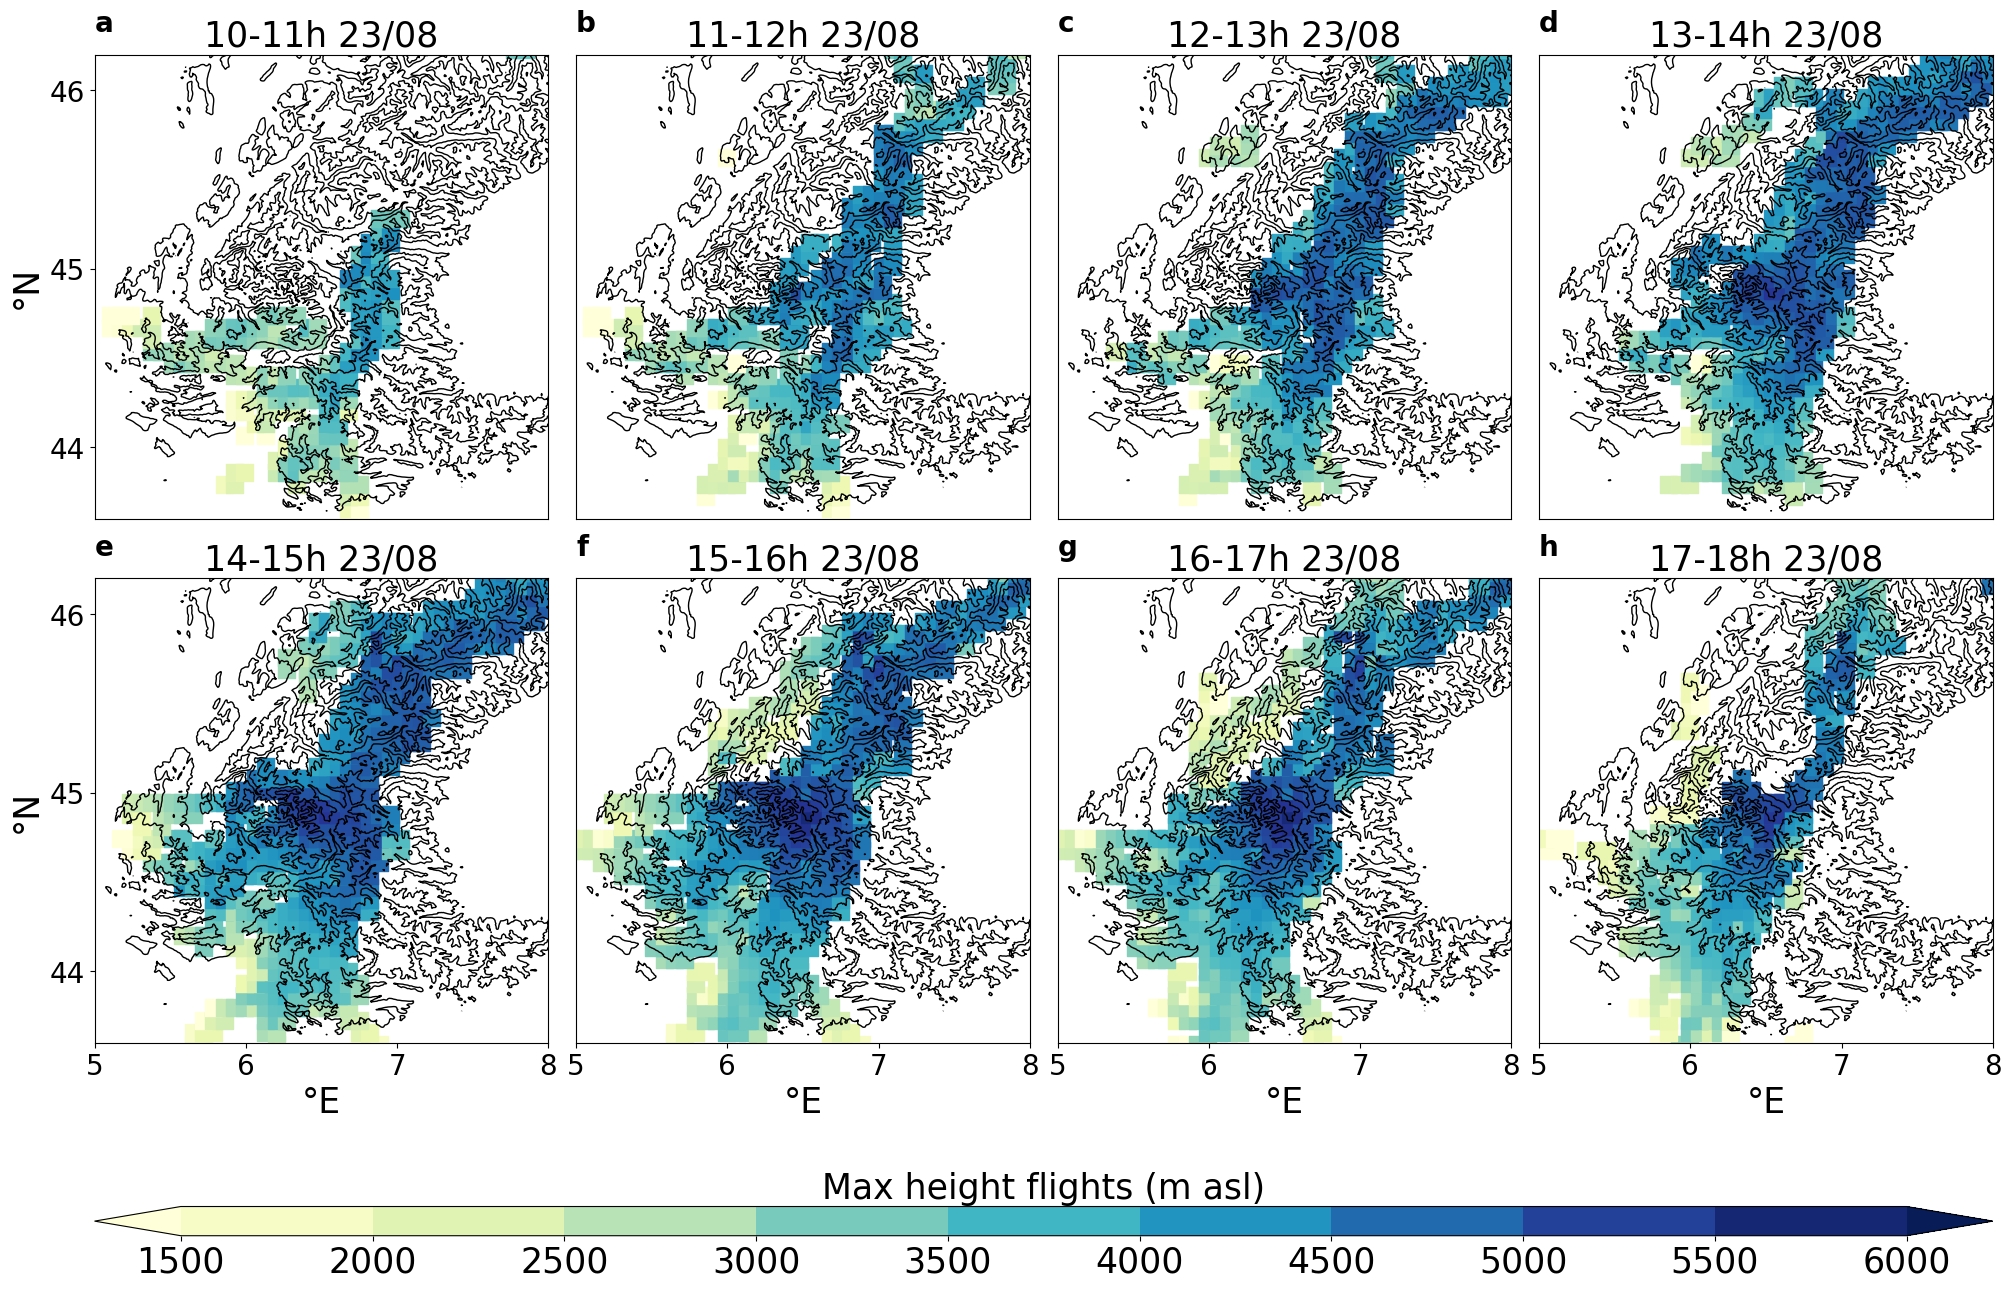

In [4]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,13), layout = 'constrained')
vmin = 1500
vmax = 6000
pas = 500
plotting_BHL_spatial(BHL_23,Elevation_father,vmin,vmax,pas,axs,23)

La prochaine cellule permet de sauvegarder les figures des 6 jours dans le dossier figure/ directement. 

In [ ]:
for i in range(6):
    
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,13), layout = 'constrained')
    vmin = 1500
    vmax = 6000
    pas = 500
    BHL = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/'+str(19+i)+'_BLH.nc')

    plotting_BHL_spatial(BHL,Elevation_father,vmin,vmax,pas,axs,19+i)
    
    plt.savefig(savefig_path+'BLH_'+str(i+19)+'.png')
    plt.close()

## Time derivative

A partir des fichiers netcdf fournit une carte de variation en $m.h^{-1}$. La couleur de chaque case correspond à la différence de la valeur du créneau [h,h+1] - [h-1,h].

In [5]:
def diff_BLH_maps(xarray,extent,dlon,dlat):
    
    res = np.ones((9,50,50))*(-9999)

    for i in tqdm(range(7)):
        xarray_h_0 = xarray.where(
            (xarray['heure'] == i+10),
            drop = True)
        xarray_h_1 = xarray.where(
            (xarray['heure'] == i+11),
            drop = True)

        for j in range(len(xarray_h_0['longitude_inf'])):
            xarray_h_1_spatial = xarray_h_1.where(
                (xarray_h_1['longitude_inf'] == xarray_h_0['longitude_inf'].values[j]) & (xarray_h_1['latitude_inf'] == xarray_h_0['latitude_inf'].values[j]),
                drop = True)
            if len(xarray_h_1_spatial['longitude_inf']) != 0 :
                indx = int((xarray_h_1_spatial['longitude_inf'] - extent[0])/dlon)
                indy = int((xarray_h_1_spatial['latitude_inf'] - extent[2])/dlat)
                if 0<=indx<50 and 0<=indy<50 :
                    res[i,indy,indx] = xarray_h_1_spatial['PBLH'].values[0] - xarray_h_0['PBLH'].values[j]

    for k in range(7):
        for i in range(50):
            for j in range(50):
                if res[k,i,j] == -9999:
                    res[k,i,j] = np.nan
                res[7,j,i] = i*dlon + extent[0]
                res[8,j,i] = j*dlat + extent[2]

    return res

def plotting_BHL_temporal(res,elevation,vmin,vmax,pas,axs,day):
    for i in range(7) :        
        x = np.ravel(res[7])        
        y = np.ravel(res[8])
        c = np.ravel(res[i])

        ax = axs[i//4,i%4]

        cax = ax.scatter(x,y,c=c,marker = 's',s = 150,vmin = vmin, vmax= vmax,cmap = 'RdBu_r')

        x = Elevation_father['lon']
        y = Elevation_father['lat']
        z = Elevation_father['elevation']
        
        ax.tricontour(x, y, z, 4, linewidths=1, colors='k')

        if i//4 == 0 :
            xticks = []
            xlabels = []
        else :
            xticks = np.arange(5,9,1)
            xlabels = [str(i) for i in xticks]
            ax.set_xlabel('°E',fontsize = 25)
            
        if i%4 != 0 :
            yticks = []
            ylabels = []
        else :
            yticks = np.arange(44,47,1)
            ylabels = [str(i) for i in yticks]
            ax.set_ylabel('°N',fontsize = 25)

        ax.set_xticks(xticks,xlabels,fontsize = 20)
        ax.set_yticks(yticks,ylabels,fontsize = 20)

        ax.set_xlim((5,8))
        ax.set_ylim((43.6,46.2))

        ax.set_title(str(i+12)+'/'+str(i+11) +'-' +str(i+10) + '/' + str(i+11)+'h ' + str(day) +'/08', fontsize = 25)
        ax.text(0, 1.05, string.ascii_lowercase[i], transform=ax.transAxes, 
                    size=20, weight='bold')
    

    ticks = np.arange(vmin,vmax+pas,pas)

    cbar = plt.colorbar(cax,
                ax = axs,
                ticks=ticks,
                format=mticker.FixedFormatter(ticks),
                extend='both',
                orientation='horizontal',
                location = 'bottom',
                fraction = 0.035,
                aspect = 65,
                label = ' ',
                boundaries = ticks)
    
    cbar.ax.tick_params(labelsize=25) 
    cbar.ax.set_title(label = 'Max Height difference (m)', fontsize=25)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.54s/it]


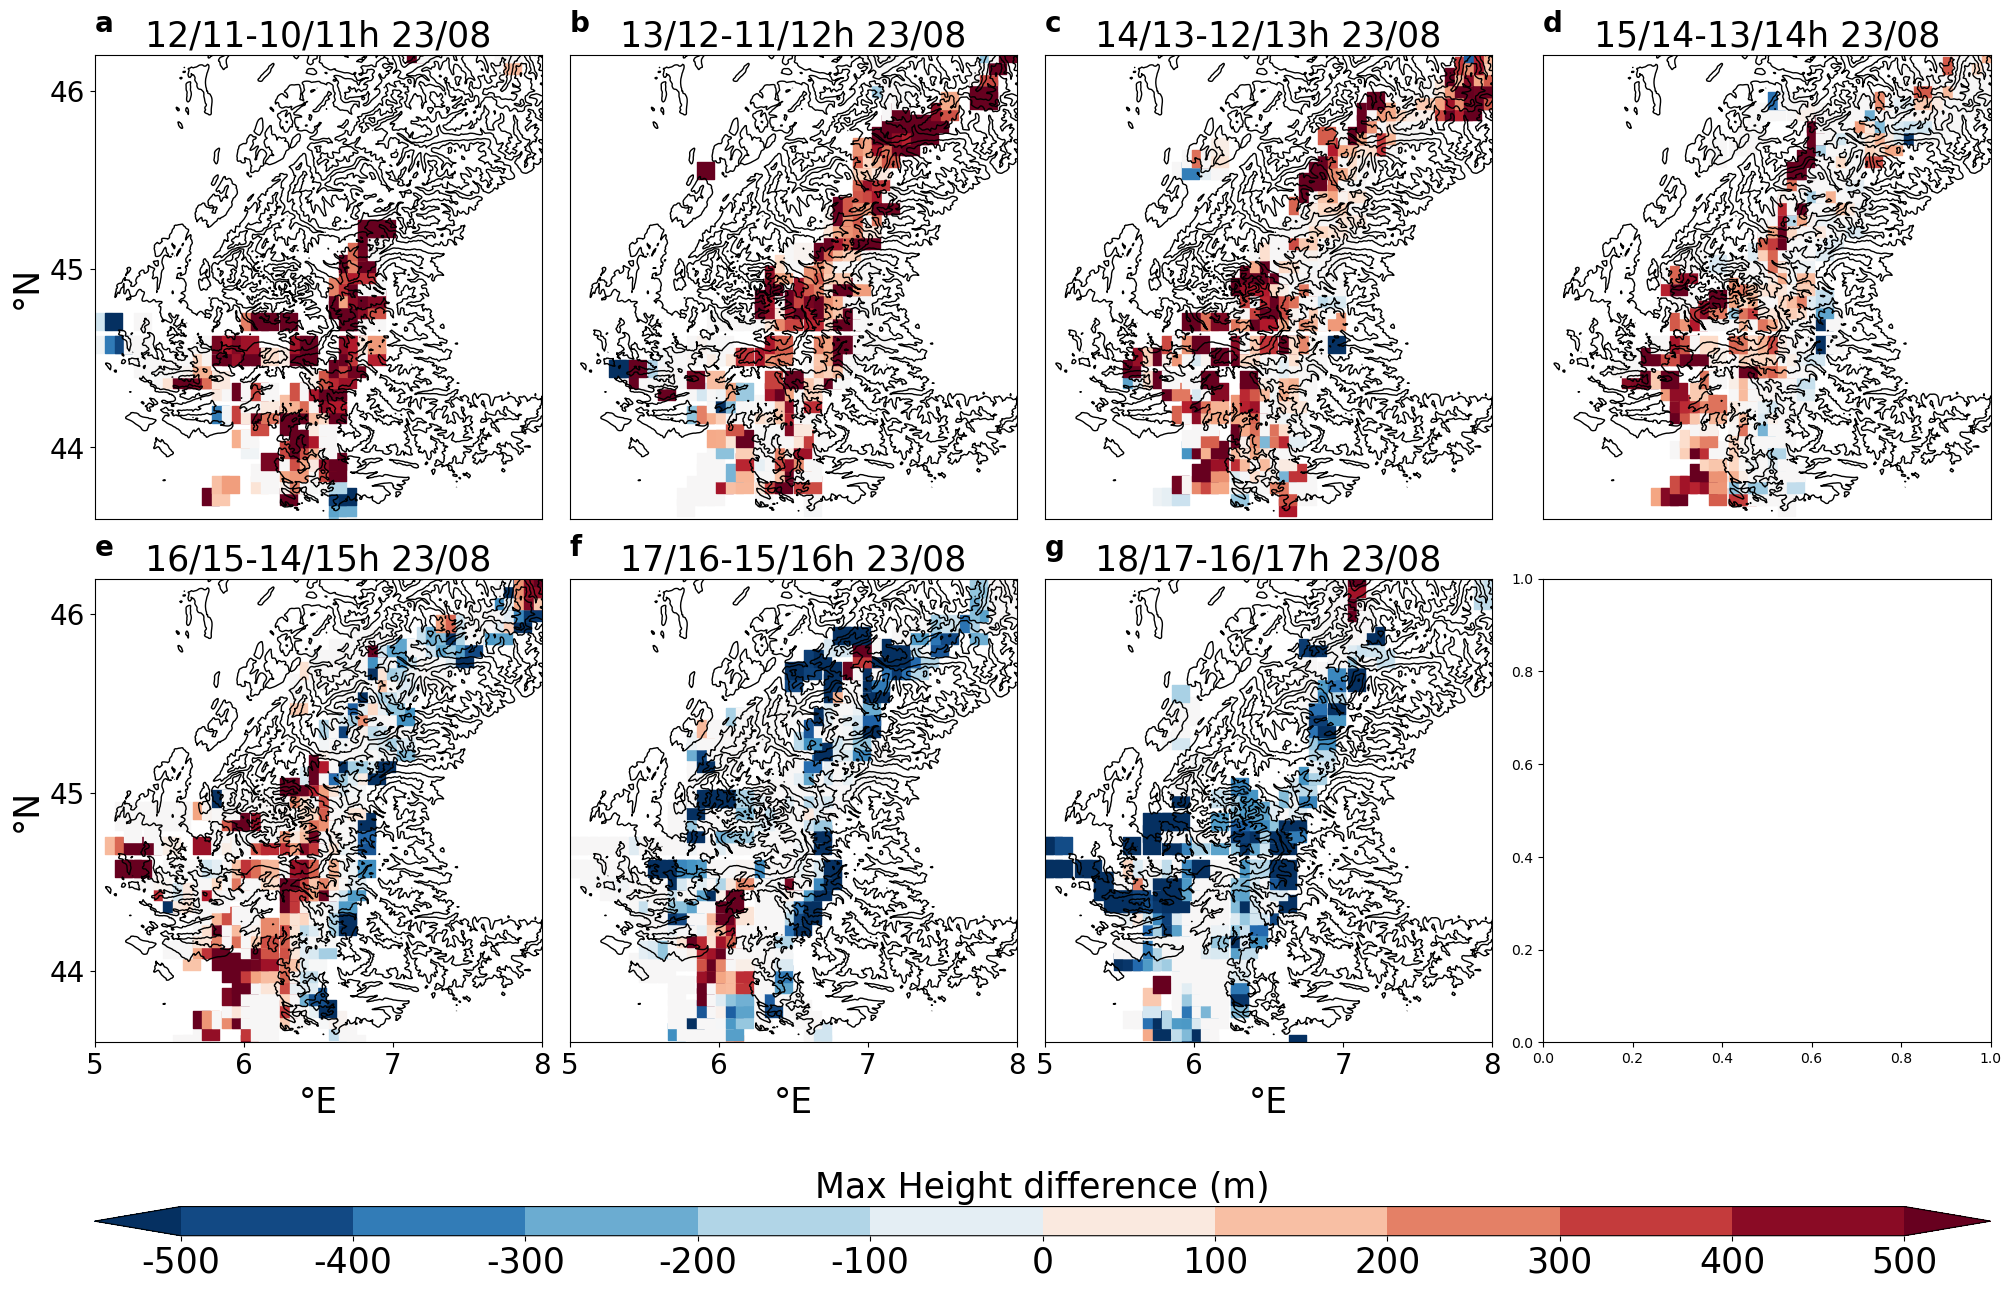

In [6]:
extent_s = (4.8, 8, 43.4, 46.6)
a = np.linspace(extent_s[0],extent_s[1],50)
b = np.linspace(extent_s[3],extent_s[2],50)
dlon = a[1] - a[0]
dlat = a[3] - a[2]

BHL =  xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/'+str(23)+'_BLH.nc')
res = diff_BLH_maps(BHL,extent_s,dlon,dlat)

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,13), layout = 'constrained')

vmin = -500
vmax = 500
pas = 100

plotting_BHL_temporal(res,Elevation_father,vmin,vmax,pas,axs,23)

plt.show()

In [ ]:
La prochaine cellule permet de sauvegarder les figures des 6 jours dans le dossier figure/ directement. 

In [ ]:
extent_s = (4.8, 8, 43.4, 46.6)
a = np.linspace(extent_s[0],extent_s[1],50)
b = np.linspace(extent_s[3],extent_s[2],50)
dlon = a[1] - a[0]
dlat = a[3] - a[2]

for day in range(6):
    BHL =  xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/'+str(day+19)+'_BLH.nc')
    res = diff_BLH_maps(BHL,extent_s,dlon,dlat)
    
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,13), layout = 'constrained')
    
    vmin = -500
    vmax = 500
    pas = 100

    plotting_BHL_temporal(res,Elevation_father,vmin,vmax,pas,axs,19+day)
    plt.savefig(savefig_path+'Derivative_BHL_'+str(day+19)+'.png')
    plt.close()